In [1]:
import keras
import numpy as np
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Lambda, Layer
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_yaml
from modAL.models import ActiveLearner
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.backend import eager_learning_phase_scope
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import math, os

from keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D

In [2]:
#pip install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html


In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [5]:
BATCH_SIZE = 256
ORIGINAL_DIM = 784
HIDDEN_DIM = 1024
EPOCH = 5
epsilon_std = 1.0
#LATENT_DIMS = [2, 4, 8, 16, 32, 64, 128, 256, 512]
LATENT_DIM = 64
usecuda=False
USE_CUDA = False
DEVICE   = ('cuda' if USE_CUDA else 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(ORIGINAL_DIM, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Linear(HIDDEN_DIM, LATENT_DIM),
        )
        
    def forward(self, X):
        return self.layers(X)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.BatchNorm1d(HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, ORIGINAL_DIM),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        return self.layers(z)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28 + LATENT_DIM, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,1),
            nn.Sigmoid()
        )
        
    def forward(self, X, z):
        Xz = torch.cat([X, z], dim=1)
        return self.layers(Xz)

In [9]:
def D_loss(DG, DE, eps=1e-6):
    loss = torch.log(DE + eps) + torch.log(1 - DG + eps)
    return -torch.mean(loss)

In [10]:
def EG_loss(DG, DE, eps=1e-6):
    loss = torch.log(DG + eps) + torch.log(1 - DE + eps)
    return -torch.mean(loss)

In [11]:
def init_weights(Layer):
    name = Layer.__class__.__name__
    if name == 'Linear':
        torch.nn.init.normal_(Layer.weight, mean=0, std=0.02)
        if Layer.bias is not None:
            torch.nn.init.constant_(Layer.bias, 0)

In [12]:
n_epochs = 400
l_rate = 2e-5

E = Encoder().to(device)
G = Generator().to(device)
D = Discriminator().to(device)

E.apply(init_weights)
G.apply(init_weights)
D.apply(init_weights)

#optimizers with weight decay
optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), 
                                lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = torch.optim.Adam(D.parameters(), 
                               lr=l_rate, betas=(0.5, 0.999), weight_decay=1e-5)

#optimizers without weight decay
# optimizer_EG = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=l_rate, betas=(0.5, 0.999))
# optimizer_D = torch.optim.Adam(D.parameters(), lr=l_rate, betas=(0.5, 0.999))

#learning rate scheduler
# lambda_ = lambda epoch: 1 if epoch < 300 else 0.978 ** (epoch-300)
# scheduler_EG = torch.optim.lr_scheduler.LambdaLR(optimizer_EG, lr_lambda=lambda_)
# scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_)

Epoch [10/400], Avg_Loss_D: 0.0039, Avg_Loss_EG: 0.0282


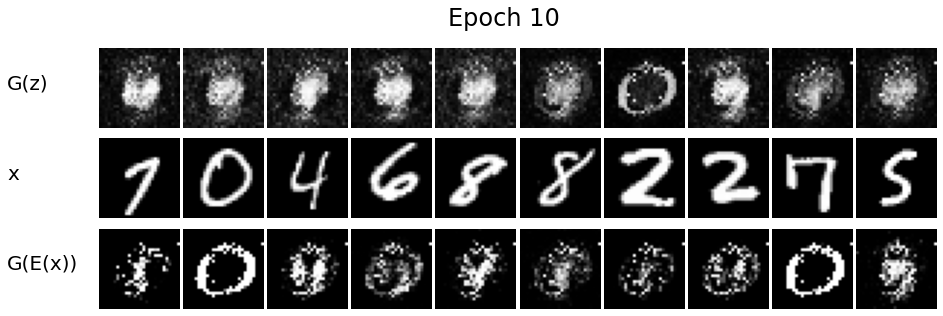

Epoch [20/400], Avg_Loss_D: 0.0042, Avg_Loss_EG: 0.0266


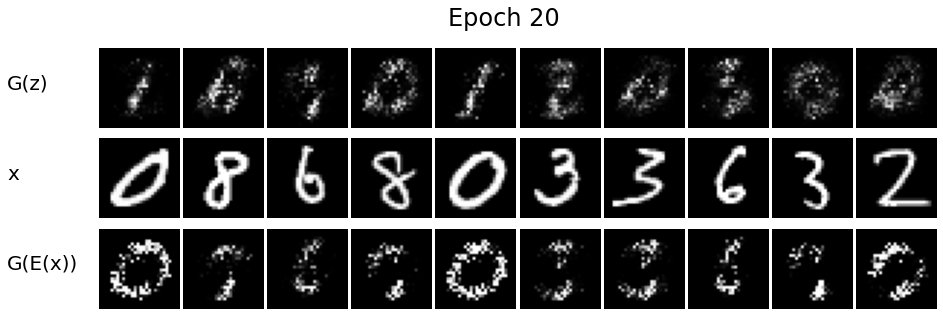

Epoch [30/400], Avg_Loss_D: 0.0035, Avg_Loss_EG: 0.0300


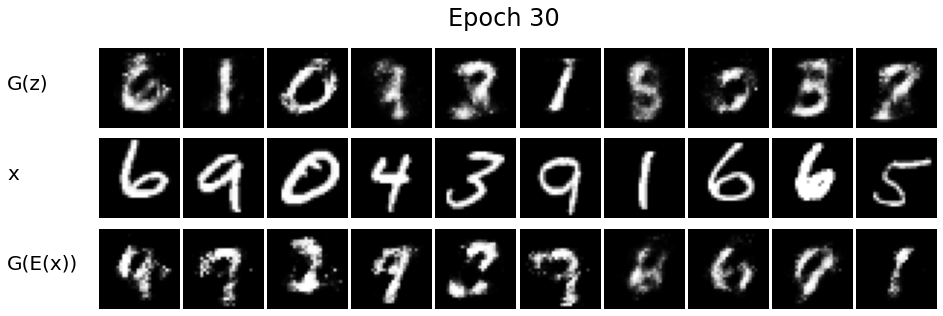

Epoch [40/400], Avg_Loss_D: 0.0042, Avg_Loss_EG: 0.0282


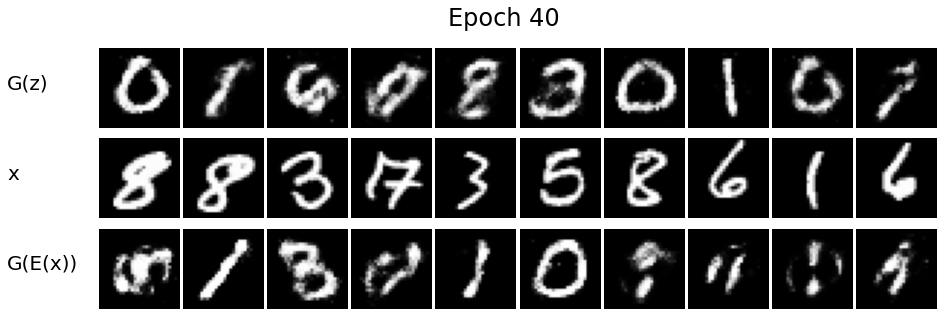

Epoch [50/400], Avg_Loss_D: 0.0046, Avg_Loss_EG: 0.0268


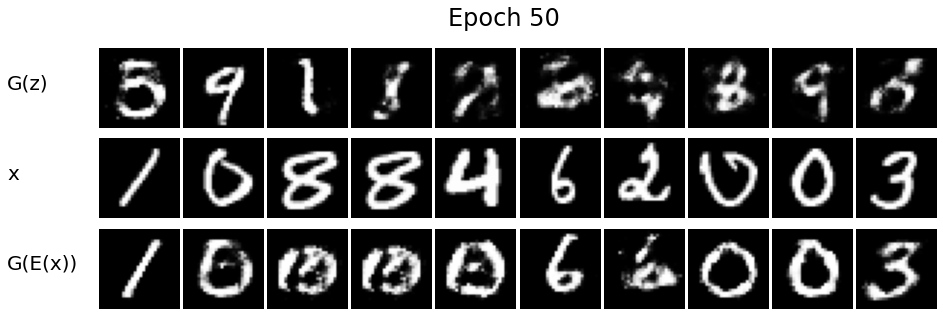

Epoch [60/400], Avg_Loss_D: 0.0050, Avg_Loss_EG: 0.0251


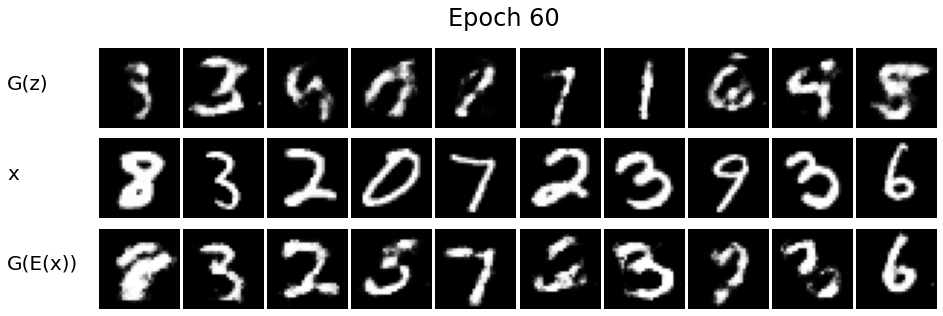

Epoch [70/400], Avg_Loss_D: 0.0054, Avg_Loss_EG: 0.0241


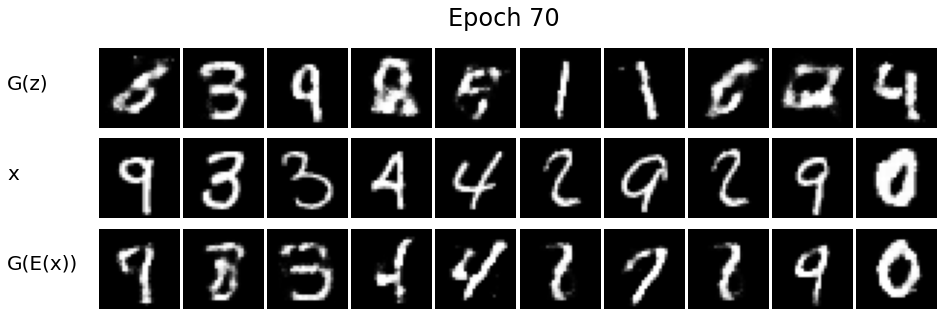

Epoch [80/400], Avg_Loss_D: 0.0058, Avg_Loss_EG: 0.0232


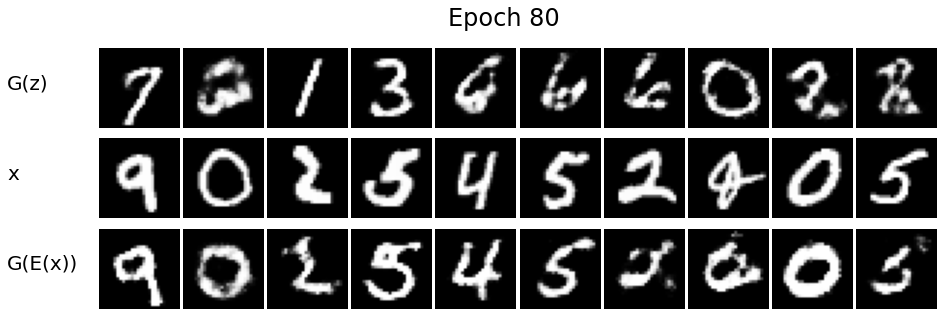

Epoch [90/400], Avg_Loss_D: 0.0060, Avg_Loss_EG: 0.0226


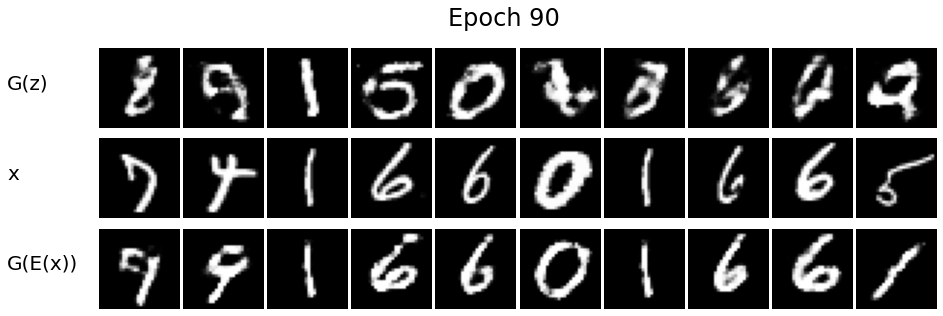

Epoch [100/400], Avg_Loss_D: 0.0063, Avg_Loss_EG: 0.0219


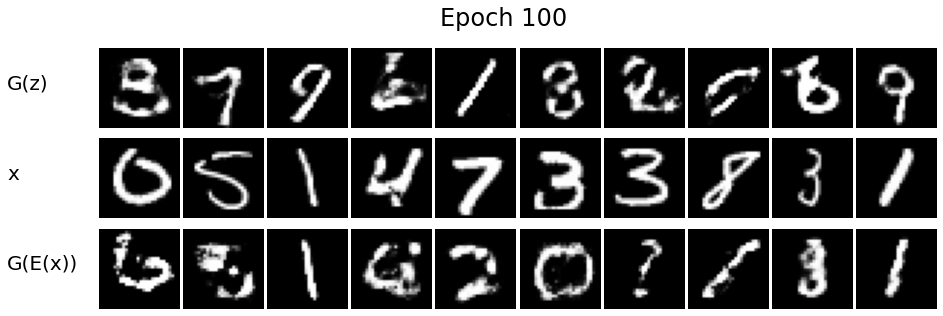

Epoch [110/400], Avg_Loss_D: 0.0065, Avg_Loss_EG: 0.0213


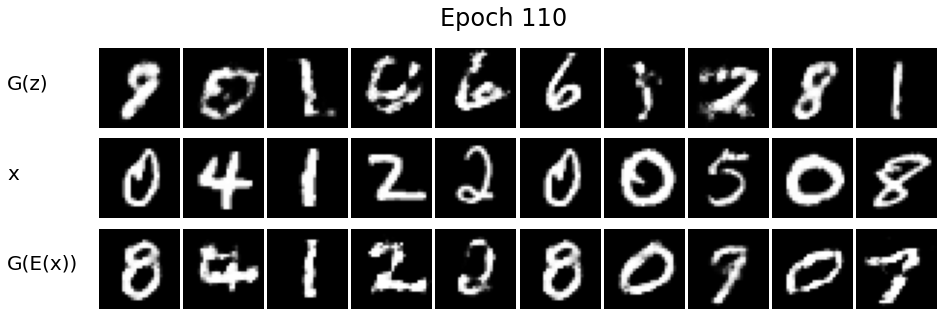

Epoch [120/400], Avg_Loss_D: 0.0067, Avg_Loss_EG: 0.0208


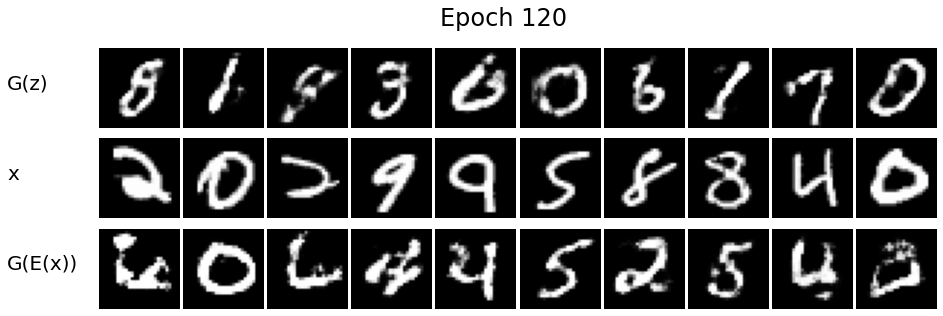

Epoch [130/400], Avg_Loss_D: 0.0069, Avg_Loss_EG: 0.0204


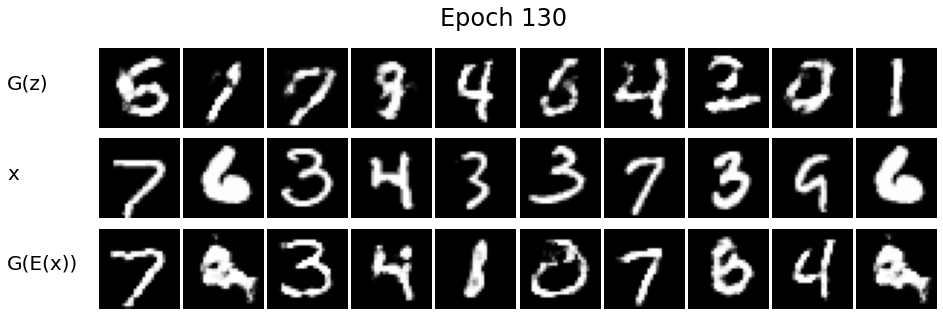

Epoch [140/400], Avg_Loss_D: 0.0071, Avg_Loss_EG: 0.0200


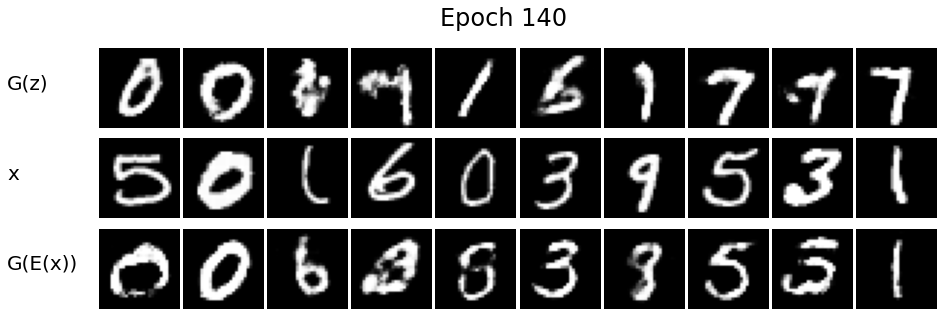

Epoch [150/400], Avg_Loss_D: 0.0071, Avg_Loss_EG: 0.0197


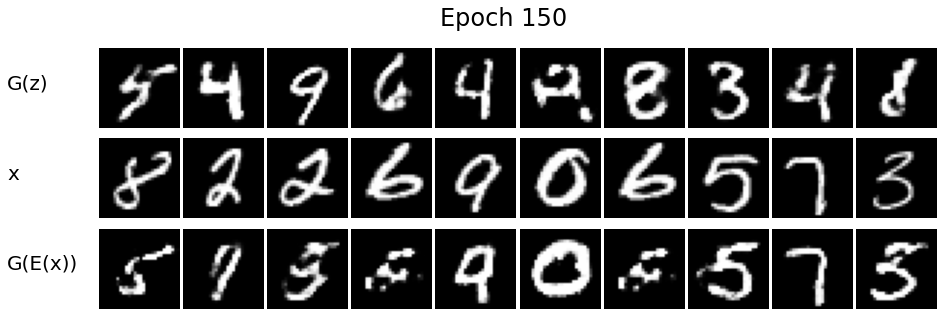

Epoch [160/400], Avg_Loss_D: 0.0072, Avg_Loss_EG: 0.0197


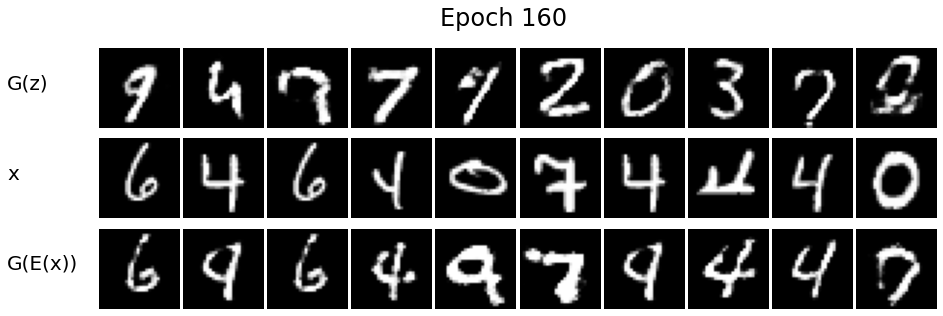

Epoch [170/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0194


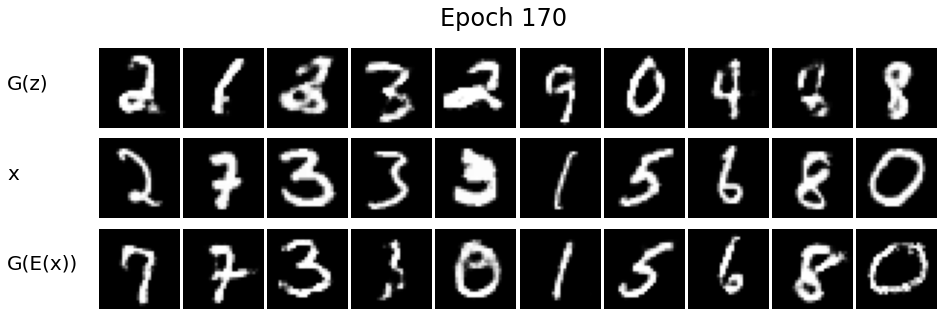

Epoch [180/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0194


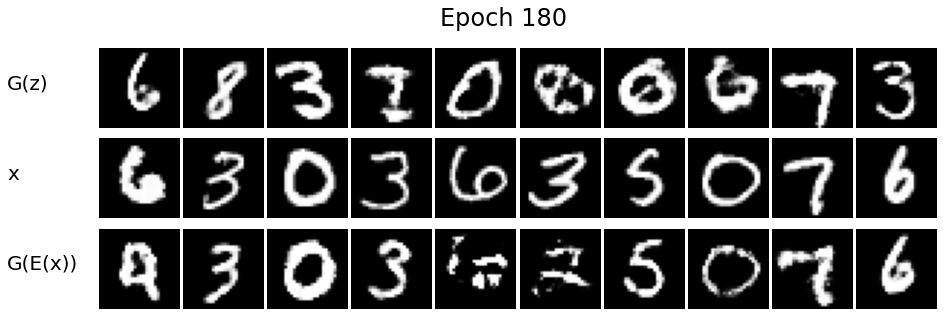

Epoch [190/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0193


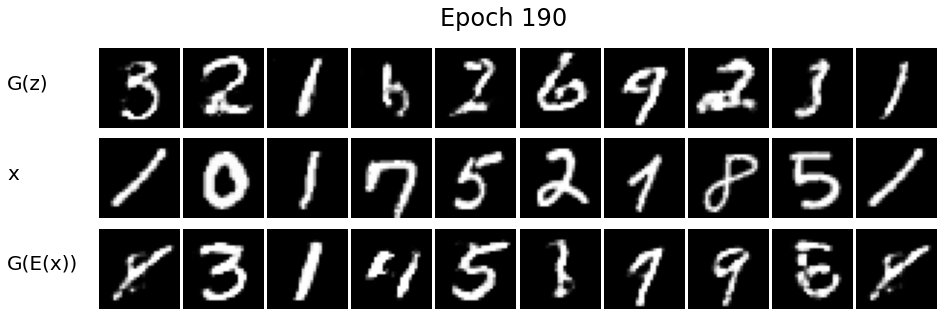

Epoch [200/400], Avg_Loss_D: 0.0074, Avg_Loss_EG: 0.0193


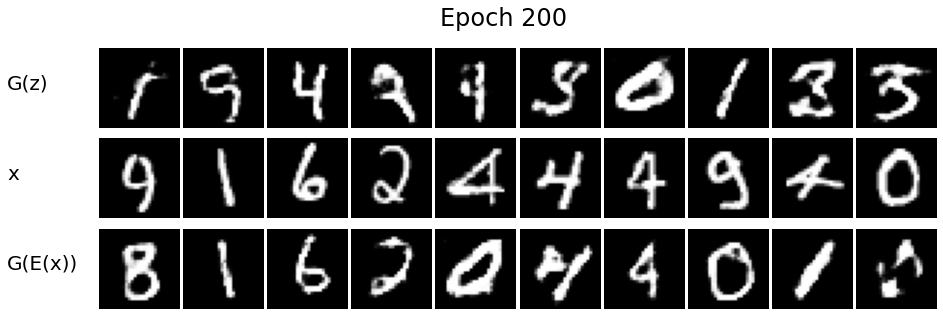

Epoch [210/400], Avg_Loss_D: 0.0074, Avg_Loss_EG: 0.0194


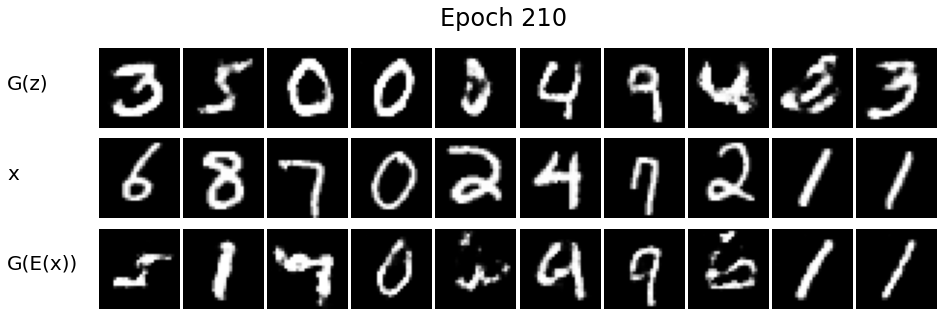

Epoch [220/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0194


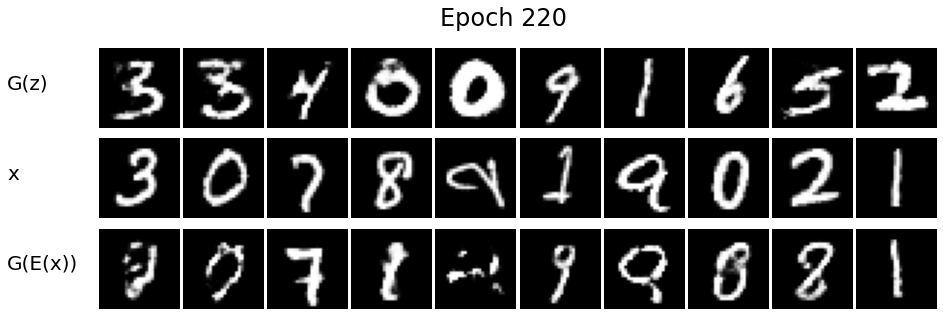

Epoch [230/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0195


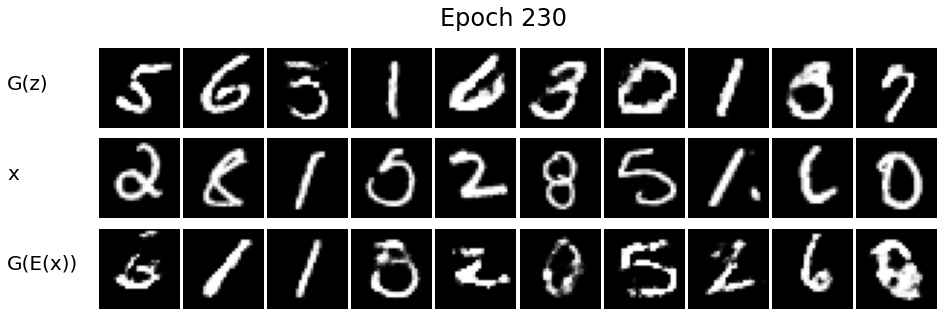

Epoch [240/400], Avg_Loss_D: 0.0073, Avg_Loss_EG: 0.0198


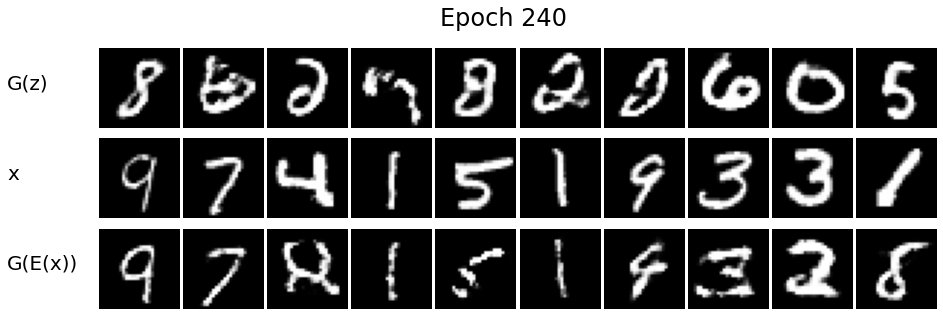

Epoch [250/400], Avg_Loss_D: 0.0072, Avg_Loss_EG: 0.0198


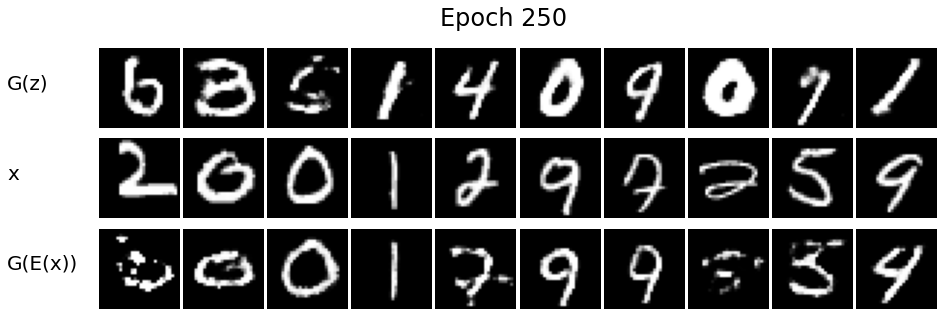

Epoch [260/400], Avg_Loss_D: 0.0072, Avg_Loss_EG: 0.0200


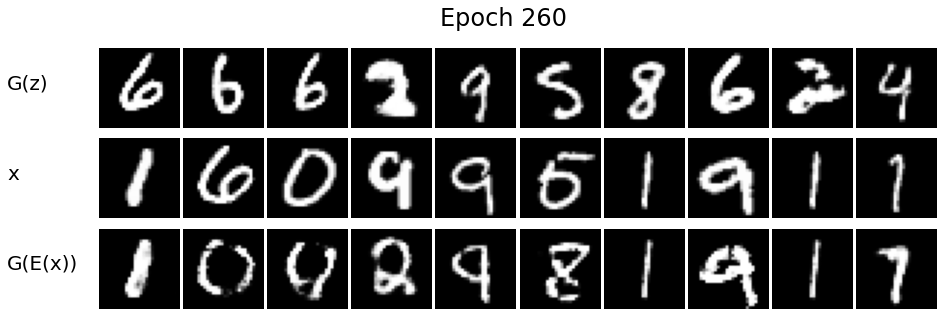

Epoch [270/400], Avg_Loss_D: 0.0071, Avg_Loss_EG: 0.0201


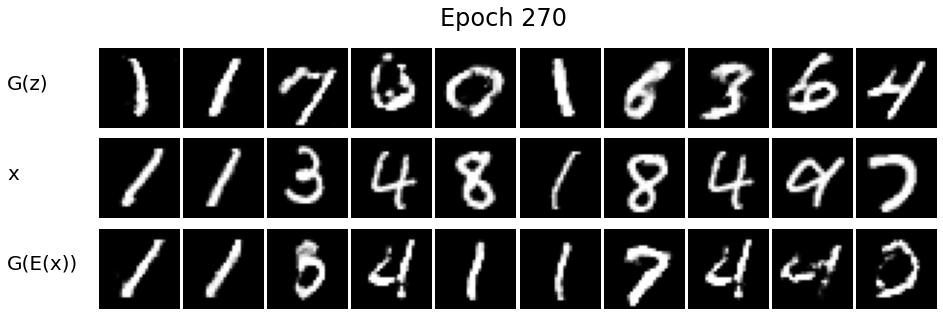

Epoch [280/400], Avg_Loss_D: 0.0071, Avg_Loss_EG: 0.0203


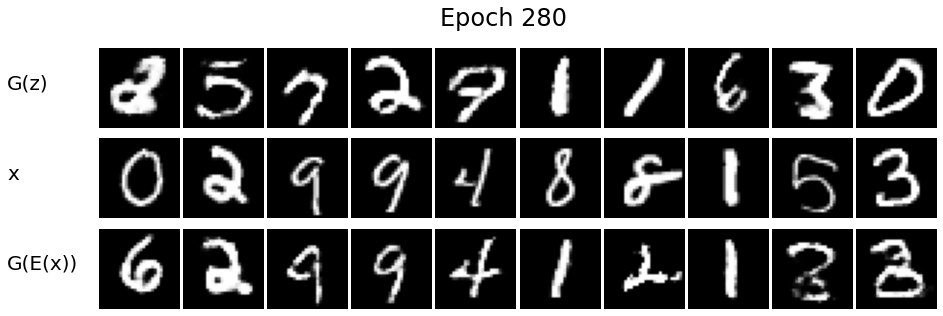

Epoch [290/400], Avg_Loss_D: 0.0070, Avg_Loss_EG: 0.0204


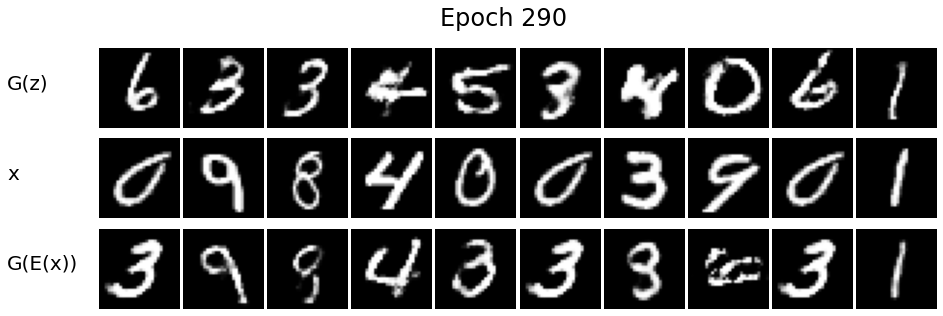

Epoch [300/400], Avg_Loss_D: 0.0070, Avg_Loss_EG: 0.0205


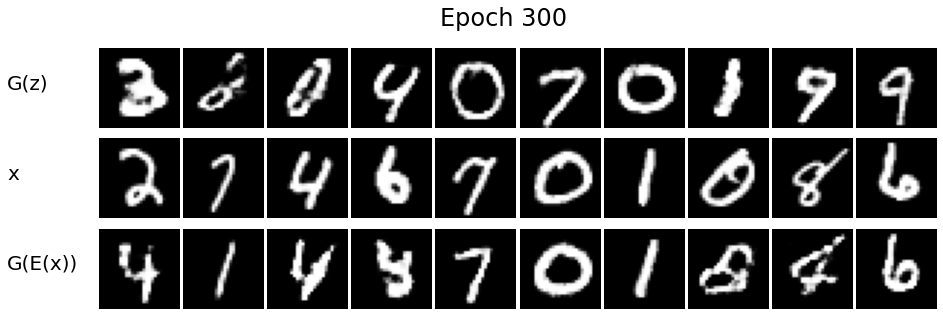

Epoch [310/400], Avg_Loss_D: 0.0069, Avg_Loss_EG: 0.0208


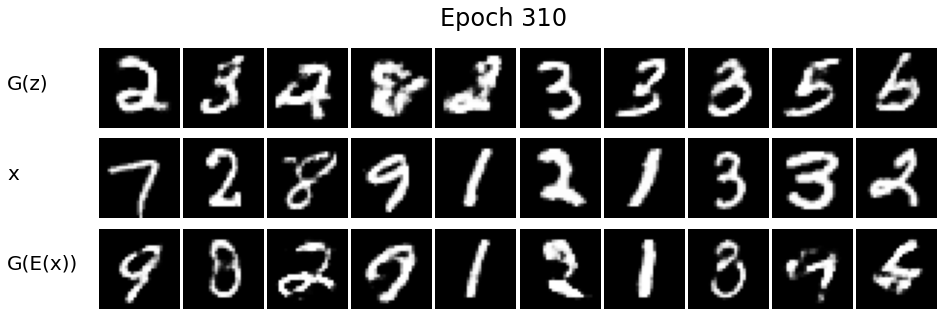

Epoch [320/400], Avg_Loss_D: 0.0068, Avg_Loss_EG: 0.0211


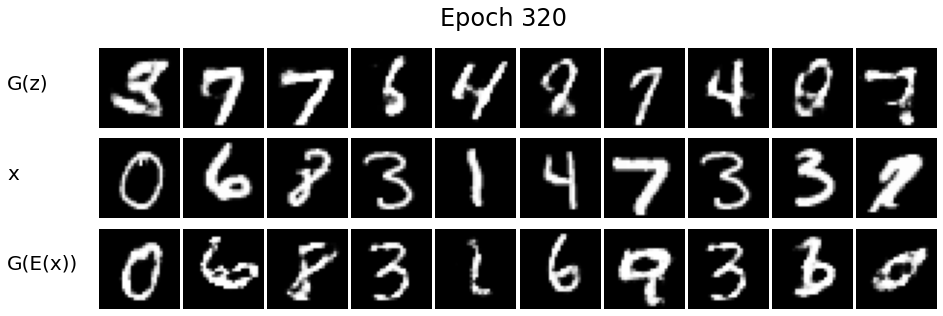

Epoch [330/400], Avg_Loss_D: 0.0068, Avg_Loss_EG: 0.0212


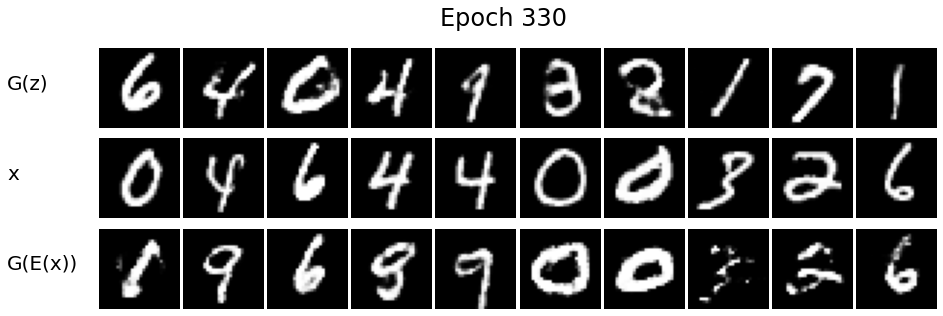

Epoch [340/400], Avg_Loss_D: 0.0067, Avg_Loss_EG: 0.0215


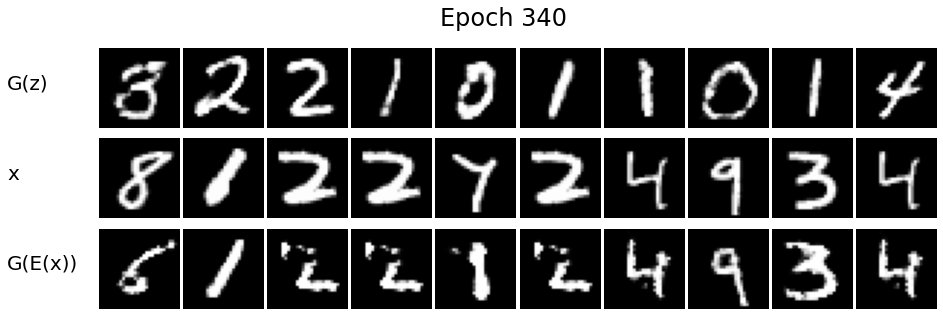

Epoch [350/400], Avg_Loss_D: 0.0066, Avg_Loss_EG: 0.0218


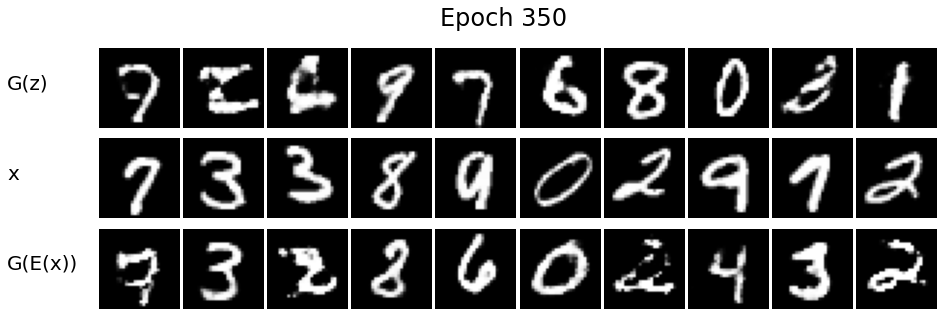

Epoch [360/400], Avg_Loss_D: 0.0066, Avg_Loss_EG: 0.0220


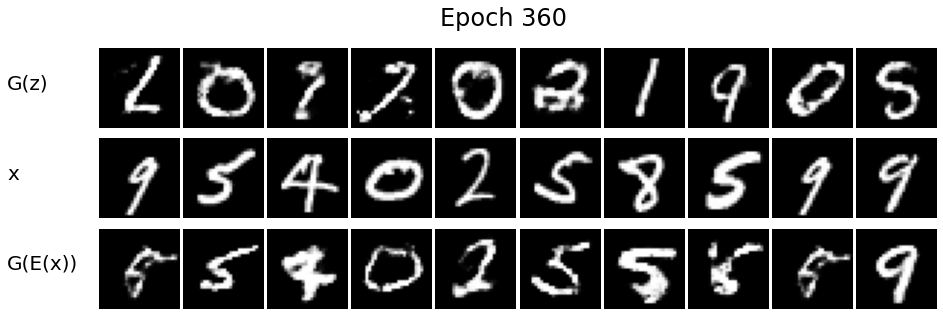

Epoch [370/400], Avg_Loss_D: 0.0065, Avg_Loss_EG: 0.0222


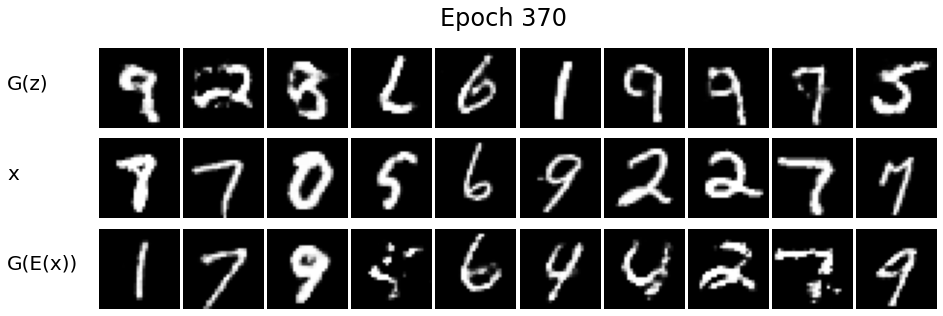

Epoch [380/400], Avg_Loss_D: 0.0064, Avg_Loss_EG: 0.0225


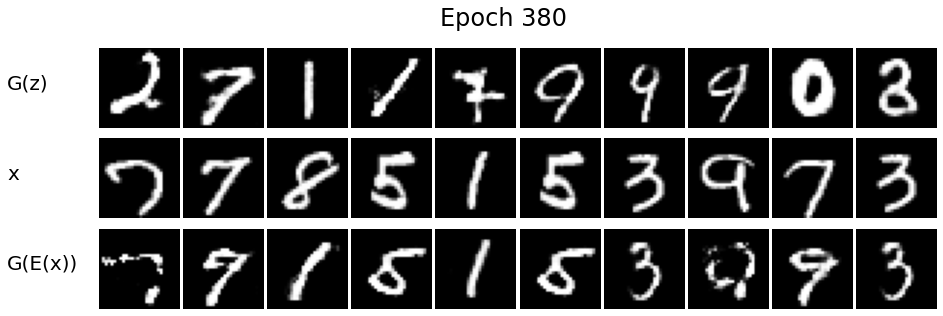

Epoch [390/400], Avg_Loss_D: 0.0063, Avg_Loss_EG: 0.0226


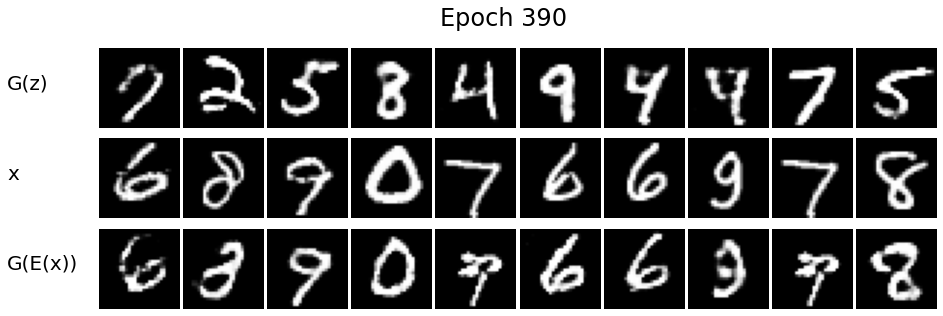

Epoch [400/400], Avg_Loss_D: 0.0064, Avg_Loss_EG: 0.0229


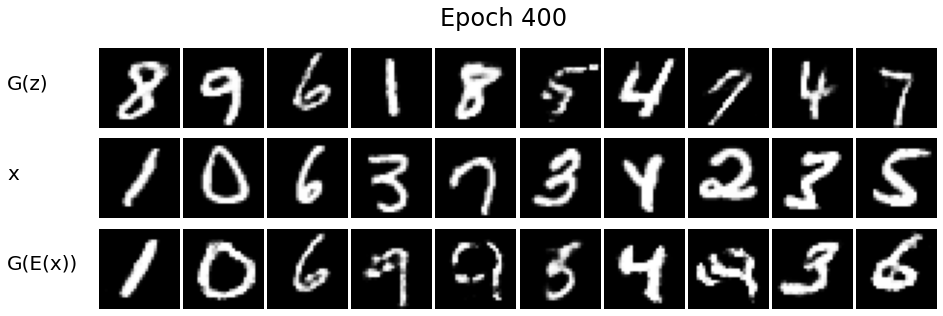

In [13]:
for epoch in range(n_epochs):
    D_loss_acc = 0.
    EG_loss_acc = 0.
    D.train()
    E.train()
    G.train()
        
#     scheduler_D.step()
#     scheduler_EG.step()

    shuffled_indices = np.arange(0, x_train.shape[0])
    np.random.shuffle(shuffled_indices)
    
    for i in range(0, len(x_train), 128): 
        end = i + 128
        if (end > len(x_train)):
            end = len(x_train)
        
        images = torch.from_numpy(x_train[shuffled_indices[i:end]]).to(device)
         
        #initialize z from 50-dim U[-1,1]
        z = 2 * torch.rand(images.shape[0], LATENT_DIM) - 1
        z = z.to(device)
        
        #compute G(z) and E(X)
        Gz = G(z)
        EX = E(images)
        
        #compute D(G(z), z) and D(X, E(X))
        DG = D(Gz, z)
        DE = D(images, EX)
        
        #compute losses
        loss_D = D_loss(DG, DE)
        loss_EG = EG_loss(DG, DE)
        D_loss_acc += loss_D.item()
        EG_loss_acc += loss_EG.item()
        
        #Discriminator training
        optimizer_D.zero_grad()
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        
        #Encoder & Generator training
        optimizer_EG.zero_grad()
        loss_EG.backward()
        optimizer_EG.step()
        
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Avg_Loss_D: {:.4f}, Avg_Loss_EG: {:.4f}'
              .format(epoch + 1, n_epochs, D_loss_acc / i, EG_loss_acc / i))
        n_show = 10
        D.eval()
        E.eval()
        G.eval()
        
        with torch.no_grad():
            indices = np.random.choice(images.shape[0], n_show)
            real = images[indices]
            z = 2 * torch.rand(n_show, LATENT_DIM) - 1
            z = z.to(device)
            gener = G(z).reshape(n_show, 28, 28).cpu().numpy()
            recon = G(E(real)).reshape(n_show, 28, 28).cpu().numpy()
            real = real.reshape(n_show, 28, 28).cpu().numpy()

            fig, ax = plt.subplots(3, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            plt.rcParams.update({'font.size': 20})
            fig.suptitle('Epoch {}'.format(epoch+1))
            fig.text(0.04, 0.75, 'G(z)', ha='left')
            fig.text(0.04, 0.5, 'x', ha='left')
            fig.text(0.04, 0.25, 'G(E(x))', ha='left')

            for i in range(n_show):
                ax[0, i].imshow(gener[i], cmap='gray')
                ax[0, i].axis('off')
                ax[1, i].imshow(real[i], cmap='gray')
                ax[1, i].axis('off')
                ax[2, i].imshow(recon[i], cmap='gray')
                ax[2, i].axis('off')
            plt.show()

In [14]:
E.eval()

X_train_enhanced = np.zeros((x_train.shape[0], LATENT_DIM), dtype="float32")

for i in range(0, len(x_train), 128): 
    end = i + 128
    if (end > len(x_train)):
        end = len(x_train)
        
    images = torch.from_numpy(x_train[i:end]).to(device)
    z_out = E(images)
    
    X_train_enhanced[i:end] = [elt.detach().numpy() for elt in z_out]
    
X_test_enhanced = np.zeros((x_test.shape[0], LATENT_DIM), dtype="float32")

for i in range(0, len(x_test), 128): 
    end = i + 128
    if (end > len(x_test)):
        end = len(x_test)
        
    images = torch.from_numpy(x_test[i:end]).to(device)
    z_out = E(images)
    
    X_test_enhanced[i:end] = [elt.detach().numpy() for elt in z_out]

In [15]:
np.save('x_train_enhanced_bigan_improved.npy', X_train_enhanced)
np.save('x_test_enhanced_bigan_improved.npy', X_test_enhanced)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, learning_rate=70, n_iter=2000, n_iter_without_progress=400, verbose=1)
EX2D = tsne.fit_transform(X_train_enhanced)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.016s...
[t-SNE] Computed neighbors for 60000 samples in 102.497s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for s

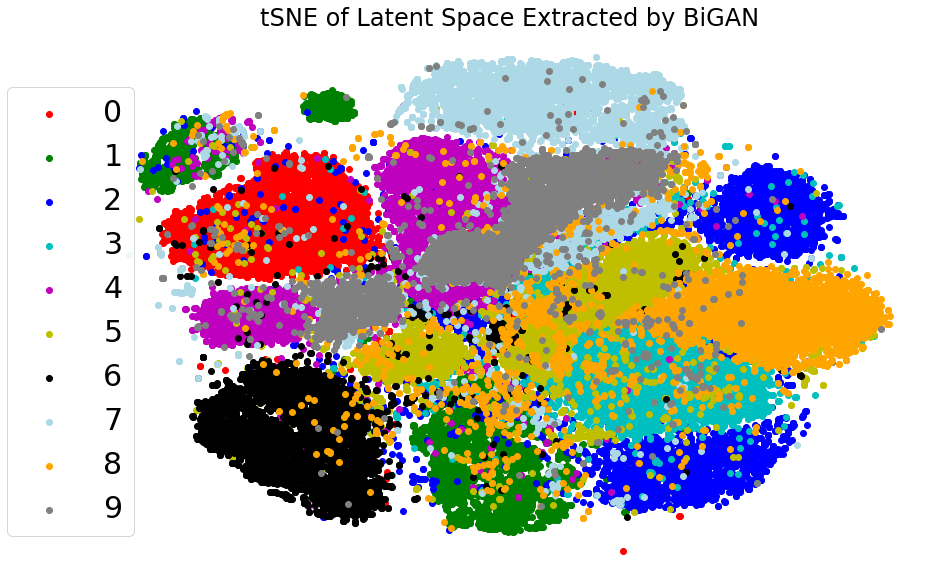

In [17]:
plt.figure(figsize=(15,10))
plt.title("tSNE of Latent Space Extracted by BiGAN")
plt.rcParams.update({'font.size': 30})
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightblue', 'orange', 'gray']

for i, c in zip(list(range(0, 10)), colors):
    idx = y_train==i
    plt.scatter(EX2D[y_train==i, 0], EX2D[y_train==i,1], c=c, label=str(i))
    
plt.legend(bbox_to_anchor=(-0.1, 0.9), loc=2, borderaxespad=0)
plt.axis('off')
plt.savefig(r'.\plots\tSNE_bigan_improved.pdf')

In [18]:
torch.save({
            'D_state_dict': D.state_dict(),
            'E_state_dict': E.state_dict(),
            'G_state_dict': G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'optimizer_EG_state_dict': optimizer_EG.state_dict(),
            #'scheduler_D_state_dict': scheduler_D.state_dict(),
            #'scheduler_EG_state_dict': scheduler_EG.state_dict()
            }, '.\models_state_dict_BiGAN.tar')